# Implementation

- Here we implement the DBSCAN algorithm on Mall Customer classification data to try to classify customers according to their income, gender, age, and spending score. 

# 1 - Data Import and Inspection

- we import the data file and inspect it for structure

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("Mall_Customers.csv")

# Quick overview
print(df.head())
print(df.info())
print(df.describe())


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  

** Remark **

- We see the column Customer ID is not relevant to our analysis, so we will drop this column. 

# 2 - Data Preprocessing

- We drop the unecessary column CustomerID, and use one-hot encode for Gender to convert it to numerical values. We then standarize the data for consistency

In [3]:
from sklearn.preprocessing import StandardScaler

# Drop ID, optional: encode 'Genre' if needed
df_clean = df.drop("CustomerID", axis=1)

# Optional: One-hot encode 'Genre'
df_clean = pd.get_dummies(df_clean, columns=['Gender'], drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)


# 3 - Initial visualization and correlation heatmap

- we plot a correlation heatmap to see the correlation between different attributes

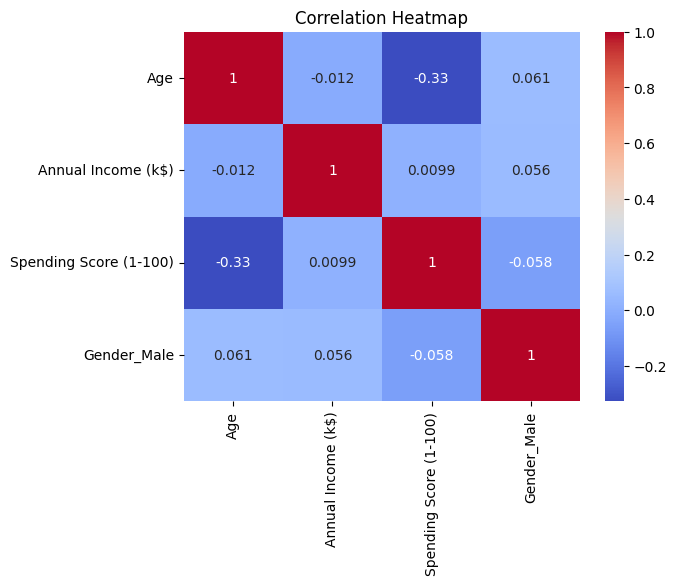

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


** Remarks **

- Some observations include:

    Being young means less income, spending

    Being male means higher income, but less spending. 

    Higher income means more spending, and more likely male.

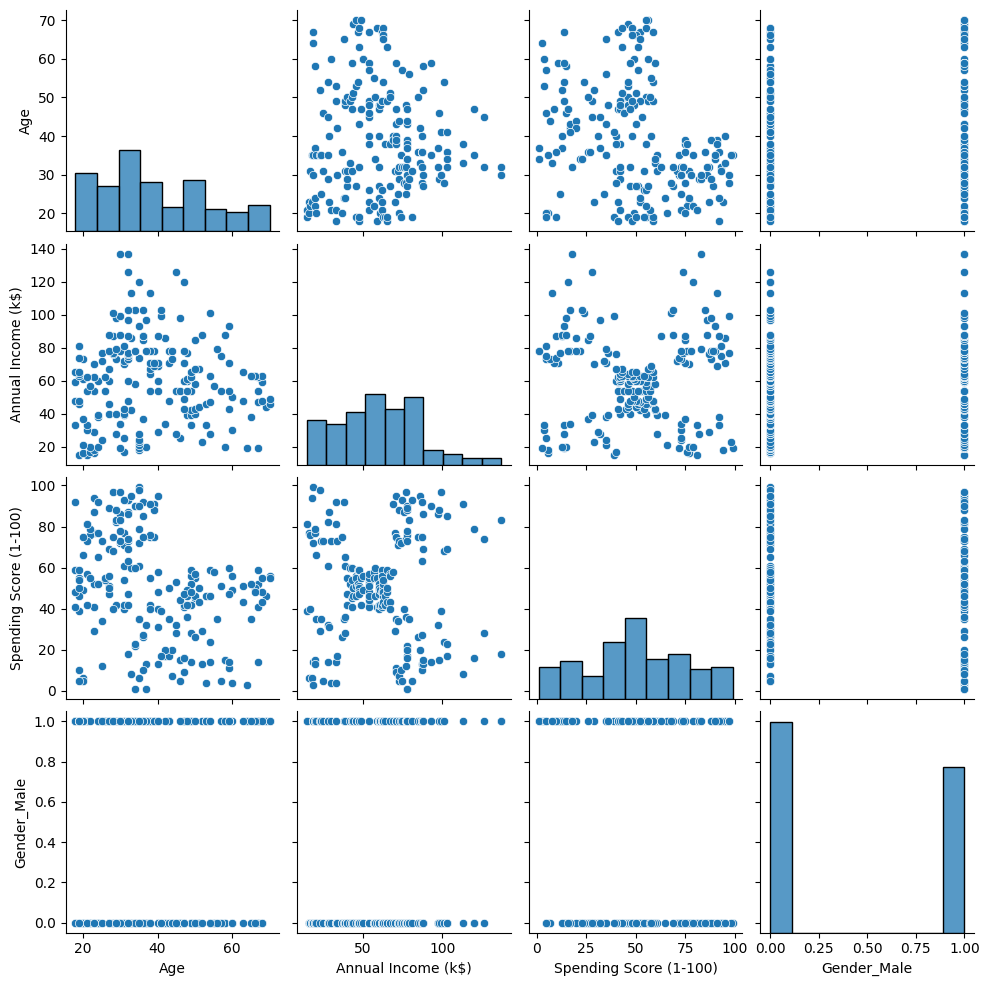

In [6]:
sns.pairplot(df_clean)
plt.show()

** Remarks **

- Not very meaningful

# 4 - PCA reduction and visualization

- We use PCA to reduce the dimentionality of the dataset, and plot it onto a 2d plot. We hope there will be clearly seperateble clusters of data

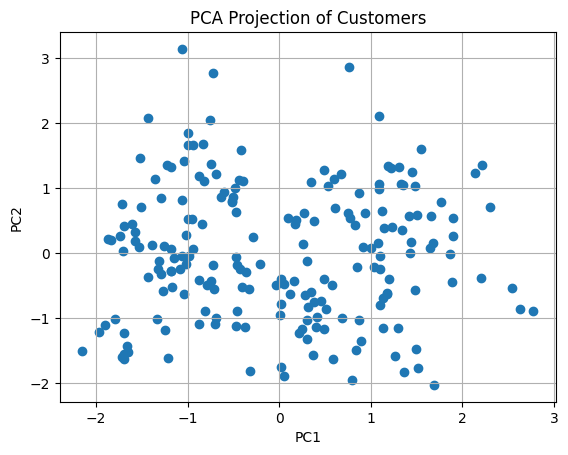

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA Projection of Customers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

** Remarks **

- while there does seem to be some areas where points cluster around, they are not nearly as clear as we would have liked. But hopefully DBSCAN can still find reasonable decision boundaries

# 5 - Estimating optimal eps

- For DBSCAN, we will want to identify a optimal value for eps. To do this, we use the elbow plot method

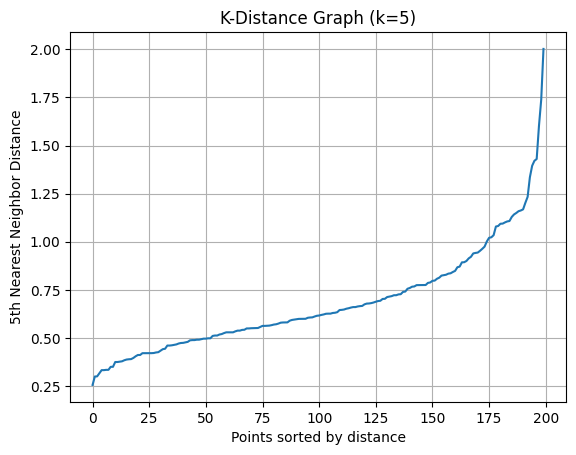

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Use standardized data (or PCA-reduced if you prefer)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to the 5th nearest neighbor
distances = np.sort(distances[:, 4])

# Plot
plt.plot(distances)
plt.title("K-Distance Graph (k=5)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid(True)
plt.show()


** Remarks **

- we see the distance sharply increasing at around 1.18, thus it will be our estimate for the eps to be passed into the DBSCAN model

# 6 - Train DBSCAN model

In [9]:
from sklearn.cluster import DBSCAN

# Based on elbow method 
dbscan = DBSCAN(eps=1.18, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Attach labels to original dataframe
df['Cluster'] = labels

# 7 - Plot DBSCAN Clusters and noise point



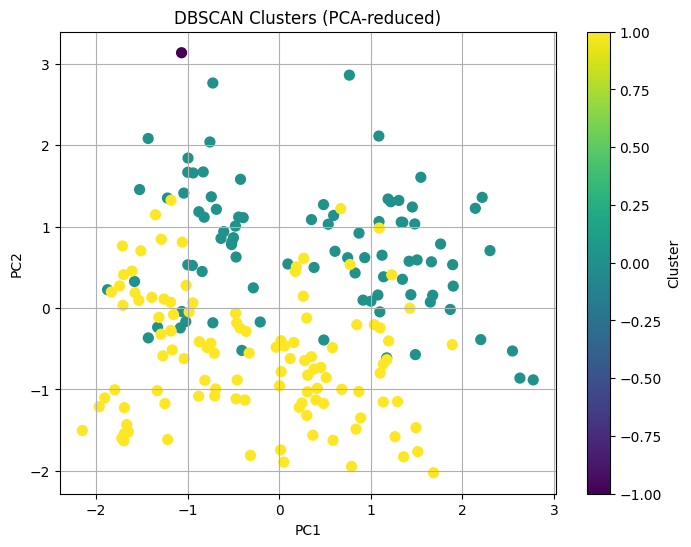

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title("DBSCAN Clusters (PCA-reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()


8 - Print out information about the clusters identified by the model

In [11]:
# Count of points per cluster
print(df['Cluster'].value_counts())

# Optional: see outliers (labeled -1)
outliers = df[df['Cluster'] == -1]
print("Outliers:\n", outliers)


Cluster
 1    112
 0     87
-1      1
Name: count, dtype: int64
Outliers:
      CustomerID Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
199         200   Male   30                 137                      83   

     Cluster  
199       -1  


In [14]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

# Assuming db is your fitted DBSCAN model and labels is db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Filter out noise for metrics that require labels
if n_clusters > 1:
    silhouette = silhouette_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)

    print(f"Silhouette Coefficient: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {ch_score:.3f}")
    print(f"Davies-Bouldin Index: {db_score:.3f}")
else:
    print("Not enough clusters for clustering metrics.")


Estimated number of clusters: 2
Estimated number of noise points: 1
Silhouette Coefficient: 0.235
Calinski-Harabasz Index: 35.652
Davies-Bouldin Index: 1.245


** Remarks **

- Silhouette Coefficient (0.235): relatively low, indicating that clusters are somewhat weakly separated and not very dense. We can kinda see where it stemmed from looking at the plot, which shows the cluster quite dispersed and overlapping in some area.

- Calinski-Harabasz Index (35.652): This metric reflects the ratio of between-cluster dispersion to within-cluster dispersion. While it's not particularly high, it suggests some separation between the clusters, but likely not tight compactness within each, again aggreeing with our visual conclusion.

- Davies-Bouldin Index (1.245): Since lower values are better, this indicates moderate cluster quality. Ideal clustering would yield values below 1.

Interpretation:

- The model managed to detect two main customer segments, but the clusters are not sharply distinct. The low silhouette score hints that DBSCAN may not have captured strong inherent groupings in the data. It's possible that either the eps or min_samples parameters need further tuning, or that the dataset lacks strong density-based structure suitable for DBSCAN.

# 9 - Fine tuning eps

- since our eps estimate was chosen by visual approximation, the best value might lie somewhere close by, so we iterate over a range of value to see if the indexes improve.

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

eps_values = [1.1, 1.13, 1.15, 1.17, 1.2]
min_samples = 5  # You can adjust this too if needed

for eps in eps_values:
    print(f"\nEvaluating DBSCAN with eps={eps}")

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"Estimated number of clusters: {n_clusters}")
    print(f"Estimated number of noise points: {n_noise}")

    if n_clusters > 1:
        silhouette = silhouette_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)

        print(f"Silhouette Coefficient: {silhouette:.3f}")
        print(f"Calinski-Harabasz Index: {ch_score:.3f}")
        print(f"Davies-Bouldin Index: {db_score:.3f}")
    else:
        print("Not enough clusters for valid clustering metrics.")



Evaluating DBSCAN with eps=1.1
Estimated number of clusters: 2
Estimated number of noise points: 7
Silhouette Coefficient: 0.255
Calinski-Harabasz Index: 36.235
Davies-Bouldin Index: 2.334

Evaluating DBSCAN with eps=1.13
Estimated number of clusters: 2
Estimated number of noise points: 5
Silhouette Coefficient: 0.253
Calinski-Harabasz Index: 35.783
Davies-Bouldin Index: 2.139

Evaluating DBSCAN with eps=1.15
Estimated number of clusters: 2
Estimated number of noise points: 4
Silhouette Coefficient: 0.257
Calinski-Harabasz Index: 35.317
Davies-Bouldin Index: 2.206

Evaluating DBSCAN with eps=1.17
Estimated number of clusters: 2
Estimated number of noise points: 1
Silhouette Coefficient: 0.235
Calinski-Harabasz Index: 35.652
Davies-Bouldin Index: 1.245

Evaluating DBSCAN with eps=1.2
Estimated number of clusters: 2
Estimated number of noise points: 1
Silhouette Coefficient: 0.235
Calinski-Harabasz Index: 35.652
Davies-Bouldin Index: 1.245


** Remarks **

- Best eps Selection: The optimal eps value in terms of the Davies-Bouldin Index appears to be 1.2, as it provides the lowest score (indicating better separation between clusters). However, the Silhouette Coefficient and Calinski-Harabasz Index suggest that clustering quality remains fairly consistent across different eps values, though slight improvements are seen at eps = 1.15. 

- Note that the scores are still very close, so no significant improvment is expected.



# Conclusion 

- We learned that DBSCAN is useful when:
    - there are no readily available labels, like in the case of the mall customers
    - There are no noticable seperable clusters.

- Our DBSCAN model was able to come up with 2 different clusters, corresponding with two types of customers that it sees as fundamentally different in their behaviors. This have very strong practical inplications, as it means DBSCAN is great for when companies want to make distinctions in its customer base and thus peronalize their offers